**Evaluation of Ichnos - Full Workshop Paper**

In [37]:
# Imports (for Graphs + Analysis)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tabulate import tabulate

sns.set_theme(style='ticks', context='paper')

In [38]:
# Read Data from TS File
def read_ts(filename):
    ts_data = {}

    with open(filename, 'r') as f:
        data = f.readlines()

    for load, row_i in zip(range(0, 100, 10), range(1,12)):
        ts_data[load] = float(data[row_i].strip().split(',')[3])

    ts_data[100] = float(data[14].strip().split(',')[3])  # power consumption with maximize stress test

    return ts_data 


def get_average_ts(node, freq):
    paths = [f'data/tasks/{node}/stats/ts-{freq}-{iteration}.csv' for iteration in range(1, 4)]

    readings = {}

    for path in paths:
        path_data = read_ts(path)

        for load,val in path_data.items():
            if load in readings:
                readings[load].append(val)
            else:
                readings[load] = [val]

    data = {}

    for load,vals in readings.items():
        data[load] = sum(vals) / 3

    return data

def get_average_ts_files(path):
    paths = [path.replace('ITER', str(iteration)) for iteration in range(1, 4)]
    readings = {}

    for path in paths:
        path_data = read_ts(path)

        for load,val in path_data.items():
            if load in readings:
                readings[load].append(val)
            else:
                readings[load] = [val]

    data = {}

    for load,vals in readings.items():
        data[load] = sum(vals) / 3

    return data

In [39]:
# Helper Functions
def plot_ts_report(node, govs):
    ts_paths = [f'data/{node}/ts/ts-{gov}-ITER.csv' for gov in govs]
    plt.figure(figsize=(6,3))
    node_stats = {}
    ts_max = 0

    for ts_path, gov in zip(ts_paths, govs):
        node_stats[f"{node}:{gov}"] = get_average_ts_files(ts_path)
        plt.plot(range(0,110,10), node_stats[f"{node}:{gov}"].values(), label=f"{node}:{gov}", marker='x')
        curr_max = max(node_stats[f"{node}:{gov}"].values())
        if curr_max > ts_max:
            ts_max = curr_max

    plt.ylim(0,ts_max+10)
    plt.xticks(range(0,110,10))
    plt.legend(loc='lower right')
    plt.show()

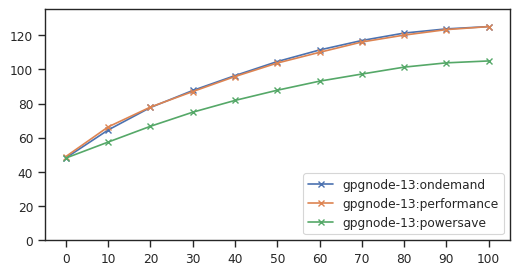

In [40]:
# Graph the Power Consumption for gpgnode-13
governors = ['ondemand', 'performance', 'powersave']
plot_ts_report('gpgnode-13', governors)

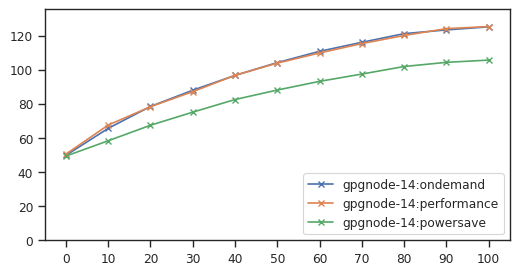

In [41]:
# Graph the Power Consumption for gpgnode-14
governors = ['ondemand', 'performance', 'powersave']
plot_ts_report('gpgnode-14', governors)

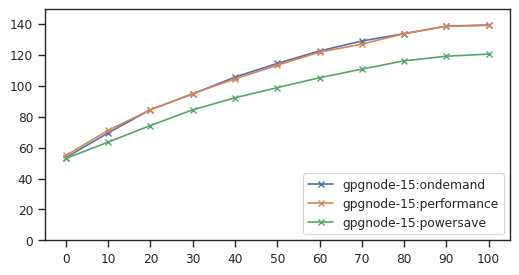

In [42]:
# Graph the Power Consumption for gpgnode-15
governors = ['ondemand', 'performance', 'powersave']
plot_ts_report('gpgnode-15', governors)

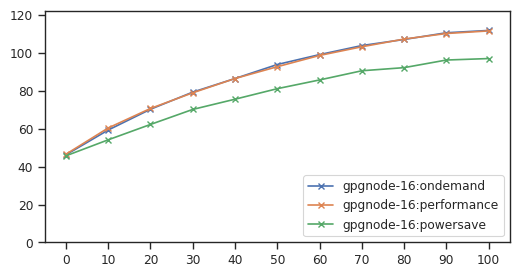

In [43]:
# Graph the Power Consumption for gpgnode-16
governors = ['ondemand', 'performance', 'powersave']
plot_ts_report('gpgnode-16', governors)

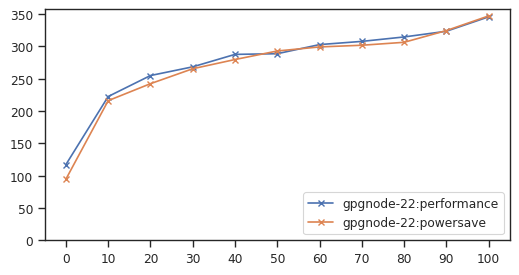

In [44]:
# Graph the Power Consumption for gpgnode-22
governors = ['performance', 'powersave']
plot_ts_report('gpgnode-22', governors)

**Observations**
- performance follows a similar pattern to ondemand on all the old GPG nodes, where there is a gap between that and power consumed using powersave
- node 15 (old GPG node) has a higher peak power consumption compared to the others, maybe less utilised, shows that not all devices will age the same
- more recent node, node 22 has close readings when comparing performance to powersave